In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
from tqdm.auto import tqdm
from string import Template
import seaborn as sn
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import plotly.express as px
from pathlib import Path
from torchmetrics import MetricCollection, Precision, Recall, F1Score, ConfusionMatrix, AUROC
from src.classifiers.zeroshot import ZeroShotClassifierWithProbs, get_system_prompt, ZeroShotClassifierWithTextOutput


BASE_DIR = Path.cwd().parent
DATA_FOLDER = BASE_DIR / "data"

metric_collection = MetricCollection([Precision(task="binary"), Recall(task="binary"), F1Score(task="binary"), AUROC(task="binary")])
conf_matrix = ConfusionMatrix(task="binary")

In [3]:
df = pl.read_json(DATA_FOLDER / "predictions.json")
df

session_id,timestamp,user,command,duration,exit_code,cwd,label,predicted_prob
str,str,str,str,f64,i64,str,str,f64
"""sid-adm001""","""2024-10-26T09:15:02Z""","""sysadmin""","""ssh sysadmin@192.168.1.10""",2.5,0,"""/home/sysadmin""","""benign""",0.377691
"""sid-adm001""","""2024-10-26T09:15:10Z""","""sysadmin""","""df -h""",0.08,0,"""/home/sysadmin""","""benign""",0.338462
"""sid-adm001""","""2024-10-26T09:15:25Z""","""sysadmin""","""free -m""",0.05,0,"""/home/sysadmin""","""benign""",0.998073
"""sid-adm001""","""2024-10-26T09:16:01Z""","""sysadmin""","""sudo apt-get update""",45.7,0,"""/home/sysadmin""","""benign""",0.999987
"""sid-adm001""","""2024-10-26T09:17:15Z""","""sysadmin""","""sudo apt-get install -y htop""",25.2,0,"""/home/sysadmin""","""benign""",0.999992
…,…,…,…,…,…,…,…,…
"""sid-theta11""","""2024-10-27T11:00:10Z""","""testuser""","""find / -perm -u=s -type f 2>/d…",22.45,0,"""/home/testuser/tests""","""malicious""",1.0
"""sid-theta11""","""2024-10-27T11:00:40Z""","""testuser""","""cp /bin/bash /tmp/bash_priv""",0.08,0,"""/home/testuser/tests""","""malicious""",0.995942
"""sid-theta11""","""2024-10-27T11:00:45Z""","""testuser""","""chmod u+s /tmp/bash_priv""",0.01,0,"""/home/testuser/tests""","""malicious""",0.999999


In [27]:
data: torch.Tensor = df.with_columns(pl.when(pl.col("label") == "malicious").then(1).otherwise(0).alias("one_hot_label")).select(["predicted_prob", "one_hot_label"]).to_torch()
pred_prob, gt = data.chunk(2, dim=1)
metric_collection(pred_prob, gt)

{'BinaryPrecision': tensor(0.5533),
 'BinaryRecall': tensor(0.7594),
 'BinaryF1Score': tensor(0.6402),
 'BinaryAUROC': tensor(0.7543)}

[]

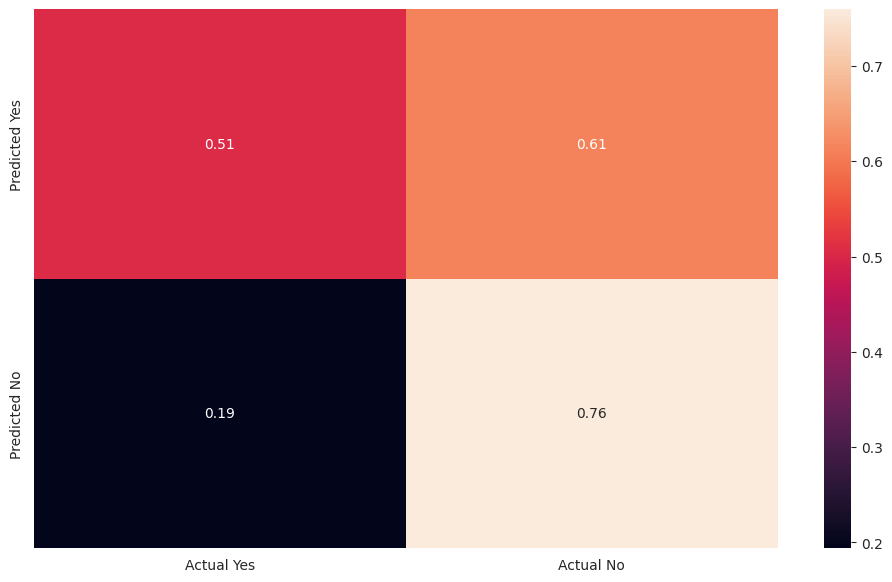

In [58]:
temp_df: pd.DataFrame = pd.DataFrame((conf_matrix(pred_prob, gt) / conf_matrix(pred_prob, gt).sum(dim=1)).numpy(), columns=["Actual Yes", "Actual No"], index=["Predicted Yes", "Predicted No"])
plt.figure(figsize = (12,7))
fig = sn.heatmap(temp_df, annot=True)
fig.plot()